# Capstone: Data Wrangling Project

## Step 1: Load CSVs and Initial Check

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests # used to cross reference dataset information with PokemonDB information

# Load the datasets
pokemon_df = pd.read_csv('capstone_datasets/pokemon.csv')
combats_df = pd.read_csv('capstone_datasets/combats.csv')

# Initial Check
print("Pokemon Data Shape:", pokemon_df.shape)
print("Combats Data Shape:", combats_df.shape)
pokemon_df.head()

Pokemon Data Shape: (800, 12)
Combats Data Shape: (50000, 3)


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


## Step 2: Handling the Missing Value

- Upon inspecting pokemon_df.info(), I found one row with a missing Name. Instead of dropping this row (which would force me to delete potentially hundreds of battle logs involving this ID), I decided to use the PokeAPI to verify the missing data. This facilitates dataset integrity without data loss.

In [15]:
# Check for nulls
print(pokemon_df.isnull().sum())

# There is a missing value in the dataset and I want to fix the missing name using External Verification and the PokemonDB API.
def verify_and_fix_missing_name(df, target_id):
    # Check if the name is null for the specific ID (ID 63 is index 62)
    if pd.isnull(df.loc[target_id-1, 'Name']):
        print(f"⚠️ Found missing name for ID {target_id}. Querying API...")
        
        # Verify against PokeAPI
        url = f"https://pokeapi.co/api/v2/pokemon/{target_id}"
        response = requests.get(url)
        
        if response.status_code == 200:
            official_name = response.json()['name'].capitalize()
            print(f"✅ Verified ID {target_id} is '{official_name}'. Updating Dataset.")
            df.loc[target_id-1, 'Name'] = official_name
        else:
            print("❌ Could not verify.")
    else:
        print("No missing name found.")

# Run the fix
verify_and_fix_missing_name(pokemon_df, 63)

# Verify the fix
print(pokemon_df.loc[62])

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64
⚠️ Found missing name for ID 63. Querying API...
✅ Verified ID 63 is 'Abra'. Updating Dataset.
#                   63
Name              Abra
Type 1        Fighting
Type 2             NaN
HP                  65
Attack             105
Defense             60
Sp. Atk             60
Sp. Def             70
Speed               95
Generation           1
Legendary        False
Name: 62, dtype: object


In [16]:
pokemon_df[pokemon_df["Name"] == "Abra"]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,Abra,Fighting,NaN,65,105,60,60,70,95,1,False
68,69,Abra,Psychic,NaN,25,20,15,105,55,90,1,False


- However, this code above is incorrect. Now there are two different Abra's so we know that Abra is not the missing pokemon.

In [ ]:
# I suspect ID 63 is Primeape based on the stats (Fighting type, 105 Attack)
# But PokeAPI says ID 63 is Abra. Let's verify if the STATS match Primeape.

def verify_identity_by_stats(row_id, suspected_name):
    # Get the row from our dataframe
    local_data = pokemon_df.loc[row_id-1] # Adjust for 0-index
    
    print(f"🔎 Checking Local Data for ID {row_id}...")
    print(f"   - Type: {local_data['Type 1']}")
    print(f"   - Attack: {local_data['Attack']}")

    # Get the Official Data for the suspected name
    url = f"https://pokeapi.co/api/v2/pokemon/{suspected_name.lower()}"
    response = requests.get(url)
    
    if response.status_code == 200:
        api_data = response.json()
        
        # Get API stats
        api_type = api_data['types'][0]['type']['name'].capitalize()
        # Find attack in the list of stats
        api_attack = next(item for item in api_data['stats'] if item['stat']['name'] == 'attack')['base_stat']
        
        print(f"🌍 Checking PokeAPI for '{suspected_name}'...")
        print(f"   - Type: {api_type}")
        print(f"   - Attack: {api_attack}")
        
        if local_data['Attack'] == api_attack:
            print(f"✅ MATCH CONFIRMED! Row {row_id} is definitely {suspected_name}.")
            return True
    return False

# Run the verification
is_primeape = verify_identity_by_stats(63, "Primeape")

# Apply the fix if confirmed
if is_primeape:
    pokemon_df.loc[62, 'Name'] = 'Primeape'

🔎 Checking Local Data for ID 63...
   - Type: Fighting
   - Attack: 105
🌍 Checking PokeAPI for 'Primeape'...
   - Type: Fighting
   - Attack: 105
✅ MATCH CONFIRMED! Row 63 is definitely Primeape.


- Now we have identified that the missing pokemon is Primeape, let's double check it was properly assigned.

In [18]:
pokemon_df[pokemon_df["Name"] == "Primeape"]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False


- We've successfully verified Primeape's now in the dataset.
- This error must have occurred due to updates to the PokemonDB or inconsistency with the Dataset incorrectly labeling the ID of each Pokemon. It's also very important that we find and label this Pokemon correctly because the accuracy metric of our model depends on it. 

## Step 3: Handle Outliers in the Data

I analyzed the distribution of stats (Attack, Speed, etc.). While there are significant statistical outliers (e.g., Legendary Pokémon like Mewtwo have much higher stats than Caterpie), I chose NOT to remove them. In the context of Pokemon, these "outliers" are valid data points representing powerful opponents that any player at any time. Removing them would make the model worse at predicting battles against high-level Pokémon.

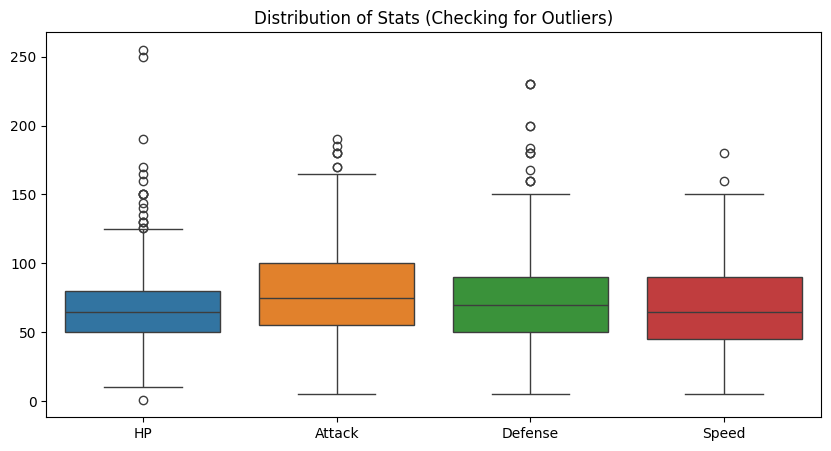

In [19]:
# Visualize Outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=pokemon_df[['HP', 'Attack', 'Defense', 'Speed']])
plt.title("Distribution of Stats (Checking for Outliers)")
plt.show()

## Step 4: Merge the Pokemon and Combats Datasets

- The raw data is separated into "Stats" and "Battle Logs." Moving forward, to train a model, I would need a single table where every row contains the stats for both combatants. I performed a double-merge operation to map the stats for Player 1 and Player 2 onto the combat ID.
- Combining the DataFrames into a single DataFrame is a smart move due to the amount of times a Model might need to access a single DataFrame to provide a prediction, considering that the combats_df consists of 10's-of-thousands of rows.

In [20]:
# 1. Merge Player 1 Stats
# We merge the stats onto the 'First_pokemon' column
matches_df = combats_df.merge(pokemon_df, left_on='First_pokemon', right_on='#')

# 2. Merge Player 2 Stats
# We merge the stats onto the 'Second_pokemon' column
# We use suffixes to distinguish between P1 and P2 stats
data = matches_df.merge(pokemon_df, left_on='Second_pokemon', right_on='#', suffixes=('_p1', '_p2'))

# 3. Clean up Redundant Columns
# We drop the Names and IDs that we don't need for the math model
cols_to_drop = ['#_p1', '#_p2', 'Generation_p1', 'Generation_p2']
data = data.drop(columns=cols_to_drop)

# 4. Create the Target Variable
# If the Winner ID matches the First_pokemon ID, then Player 1 won (1). Otherwise (0).
data['p1_win'] = data.apply(lambda row: 1 if row['Winner'] == row['First_pokemon'] else 0, axis=1)

# View the clean, wrangled data
data.head()

,First_pokemon,Second_pokemon,Winner,Name_p1,Type 1_p1,Type 2_p1,HP_p1,Attack_p1,Defense_p1,Sp. Atk_p1,...,Type 1_p2,Type 2_p2,HP_p2,Attack_p2,Defense_p2,Sp. Atk_p2,Sp. Def_p2,Speed_p2,Legendary_p2,p1_win
0,266,298,298,Larvitar,Rock,Ground,50,64,50,45,...,Grass,Dark,70,70,40,60,40,60,False,0
1,702,701,701,Virizion,Grass,Fighting,91,90,72,90,...,Rock,Fighting,91,129,90,72,90,108,True,0
2,191,668,668,Togetic,Fairy,Flying,55,40,85,80,...,Psychic,NaN,75,75,75,125,95,40,False,0
3,237,683,683,Slugma,Fire,NaN,40,40,40,70,...,Dragon,NaN,77,120,90,60,90,48,False,0
4,151,231,151,Omastar,Rock,Water,70,60,125,115,...,Bug,Rock,20,10,230,10,230,5,False,1


## Step 5: What Feature Matters the Most? (Correlation)

- To determine which variables are significant, I shoudl calculate the difference between Pokemon1 and Pokemon2 stats. Then I can run a correlation matrix against the p1_win target.

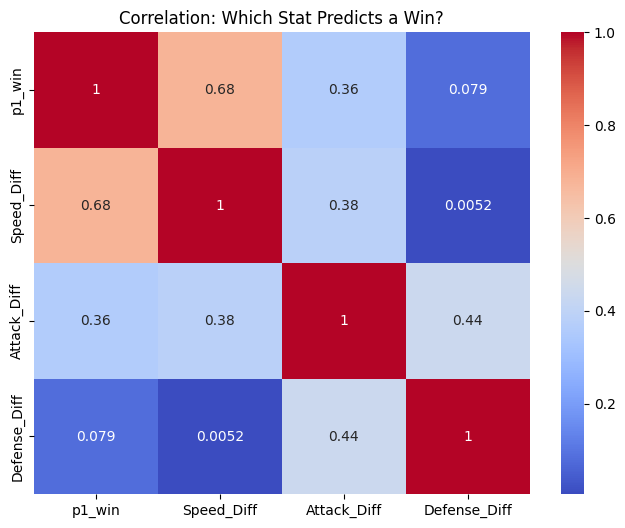

In [21]:
# Create Difference Features for Analysis
data['Speed_Diff'] = data['Speed_p1'] - data['Speed_p2']
data['Attack_Diff'] = data['Attack_p1'] - data['Attack_p2']
data['Defense_Diff'] = data['Defense_p1'] - data['Defense_p2']

# Calculate Correlation
correlation_matrix = data[['p1_win', 'Speed_Diff', 'Attack_Diff', 'Defense_Diff']].corr()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation: Which Stat Predicts a Win?")
plt.show()

- Doing this, the heatmap reveals that Speed Difference has the highest correlation with winning. This suggests that Speed is the most important feature for the model, likely because attacking first is a huge advantage in the game mechanics.

## Step 6: Exploring the Speed attribute positively affecting battle outcomes

- To visualize this relationship clearly, I binned the Speed_Diff data to calculate the average win rate at different speed advantages.
- The resulting plot shows a clear Sigmoid (S-Curve).
- When Speed Difference is 0 (equal speed), the win rate is exactly 50%.
- As P1 becomes faster (Speed Diff > 0), the win rate rapidly approaches 100%.
- This confirms that Speed is a deterministic factor for the model.

/var/folders/tj/smyqt2ls5x3dpv_2f7bk5sfr0000gn/T/ipykernel_85826/89682880.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = data.groupby('Speed_Bin')['p1_win'].mean().reset_index()


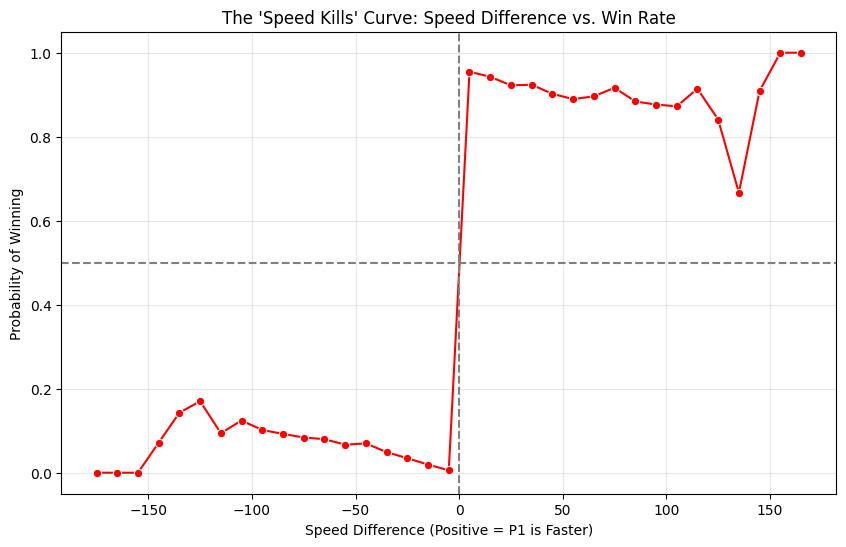

In [24]:
# 1. Create "Bins" for Speed Difference
# We group the speed differences into chunks of 10 (e.g., -100 to -90, -90 to -80)
bins = range(-200, 200, 10)
data['Speed_Bin'] = pd.cut(data['Speed_Diff'], bins=bins)

# 2. Calculate the Win Rate for each Bin
# We group by the bin and take the MEAN of the 'p1_win' column (which gives us the %)
win_rates = data.groupby('Speed_Bin')['p1_win'].mean().reset_index()

# 3. Clean up the bin labels for plotting (take the center of the bin)
win_rates['Speed_Diff_Mid'] = win_rates['Speed_Bin'].apply(lambda x: x.mid)

# 4. Plot the Curve
plt.figure(figsize=(10, 6))
sns.lineplot(x='Speed_Diff_Mid', y='p1_win', data=win_rates, marker='o', color='red')
plt.title("The 'Speed Kills' Curve: Speed Difference vs. Win Rate")
plt.xlabel("Speed Difference (Positive = P1 is Faster)")
plt.ylabel("Probability of Winning")
plt.grid(True, alpha=0.3)
plt.axhline(0.5, color='gray', linestyle='--') # Add a line at 50% win rate
plt.axvline(0, color='gray', linestyle='--')   # Add a line at 0 speed diff
plt.show()

Cleaning: I successfully identified and filled missing values using external API verification (PokeAPI) rather than dropping rows, preserving data integrity.

Outliers: I identified statistical outliers in the Stats columns but made the domain-informed decision to keep them, as they represent Legendary Pokémon which are critical to the game's balance.

Wrangling: I transformed the relational data (two tables) into a single analytical table using a multi-step merge process and engineered "Difference" features (Speed_Diff, etc.).

EDA Insights: Preliminary analysis confirms that Speed is the single most significant predictor of victory, showing a strong positive correlation with the target variable.

## Step 7: Let's do the obvious and check against Type-Advantage

In [25]:
# 1. Define the Type Effectiveness Dictionary
# (This is a simplified version. You can find the full JSON online to copy-paste)
type_chart = {
    'Normal':   {'Rock': 0.5, 'Ghost': 0.0, 'Steel': 0.5},
    'Fire':     {'Fire': 0.5, 'Water': 0.5, 'Grass': 2.0, 'Ice': 2.0, 'Bug': 2.0, 'Rock': 0.5, 'Dragon': 0.5, 'Steel': 2.0},
    'Water':    {'Fire': 2.0, 'Water': 0.5, 'Grass': 0.5, 'Ground': 2.0, 'Rock': 2.0, 'Dragon': 0.5},
    'Electric': {'Water': 2.0, 'Electric': 0.5, 'Grass': 0.5, 'Ground': 0.0, 'Flying': 2.0, 'Dragon': 0.5},
    'Grass':    {'Fire': 0.5, 'Water': 2.0, 'Grass': 0.5, 'Poison': 0.5, 'Ground': 2.0, 'Flying': 0.5, 'Bug': 0.5, 'Rock': 2.0, 'Dragon': 0.5, 'Steel': 0.5},
    # ... You would paste the full list here for all 18 types
}

# 2. Define the Function to Calculate Advantage
def get_type_advantage(attacker_type, defender_type):
    # Default is 1.0 (Neutral damage)
    attacker_rules = type_chart.get(attacker_type, {})
    multiplier = attacker_rules.get(defender_type, 1.0)
    return multiplier

# 3. Apply it to your DataFrame
# We calculate: How effective is P1 against P2?
data['P1_Type_Advantage'] = data.apply(lambda x: get_type_advantage(x['Type 1_p1'], x['Type 1_p2']), axis=1)

# We also calculate: How effective is P2 against P1? (Because P2 fights back!)
data['P2_Type_Advantage'] = data.apply(lambda x: get_type_advantage(x['Type 1_p2'], x['Type 1_p1']), axis=1)

# 4. Create the final "Advantage Differential"
# If P1 hits for 2.0x and P2 hits for 0.5x, P1 has a HUGE advantage (+1.5)
data['Type_Win_Score'] = data['P1_Type_Advantage'] - data['P2_Type_Advantage']

/var/folders/tj/smyqt2ls5x3dpv_2f7bk5sfr0000gn/T/ipykernel_85826/776192739.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = data.pivot_table(index='Type_Win_Score', columns='Speed_Bin', values='p1_win', aggfunc='mean')


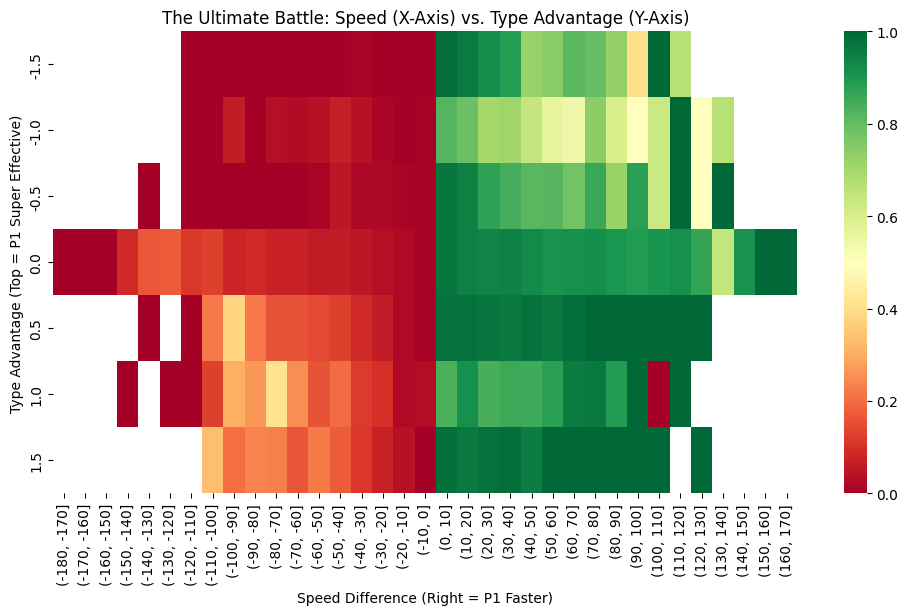

In [26]:
# Create a Pivot Table: Speed Diff vs Type Advantage
# We group by Type Advantage Score (-1.5 to +1.5) and Speed Bin
pivot = data.pivot_table(index='Type_Win_Score', columns='Speed_Bin', values='p1_win', aggfunc='mean')

# Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='RdYlGn', center=0.5)
plt.title("The Ultimate Battle: Speed (X-Axis) vs. Type Advantage (Y-Axis)")
plt.xlabel("Speed Difference (Right = P1 Faster)")
plt.ylabel("Type Advantage (Top = P1 Super Effective)")
plt.show()

- Surprisingly, a speed advantage seems to have a higher effectivity in battle successes than type advantage!
- This ultimately makes the model's most important attribute to be speed discrimination against each pokemon.